In [1]:
from __future__ import division

import numpy as np
import os
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as stats
import imageio
import warnings

from sklearn.cluster import AgglomerativeClustering
from scipy.stats import norm
from IPython.display import clear_output
from PIL import Image
import sys
if sys.version_info[0]>=3:
    from importlib import reload

#### Do you want to show figures in the notebook?
#### Do you want to save them?

In [2]:
show_fig = False
save_fig = True

In [3]:
## Assign project directory
main_dir = os.path.abspath('../../') + '/'

## Assign paths where features can be found
# data_dir = '/Volumes/ntb/projects/sketchloop02/data'
data_dir = os.path.join(main_dir,'data')
path_to_recog = str(data_dir) + '/features/recog'
path_to_draw = str(data_dir) + '/features/drawing'

#Where to put plots
put_plots = str(main_dir) + 'plots/4_informational_connectivity_during_drawing/'

roi_list = np.array(['V1Draw', 'V2Draw', 'LOCDraw', 'parietalDraw', 
                     'smgDraw', 'sensoryDraw', 'motorDraw', 'frontalDraw'])

In [4]:
## add helpers to python path
if str(main_dir)+'python' not in sys.path:
    sys.path.append(str(main_dir)+'python')
    
# Suppress warnings to avoid output
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# Assign variables within imported analysis helpers
import analysis_helpers
if sys.version_info[0]>=3:
    from importlib import reload
reload(analysis_helpers)

analysis_helpers.path_to_recog = path_to_recog
analysis_helpers.path_to_draw = path_to_draw

In [6]:
#### Helper data loader functions

def preprocess_recog(RECOG_METAS, RECOG_FEATS):
    M = [i for i in RECOG_METAS if len(i.split('.')[0].split('_'))==4]
    F = [i for i in RECOG_FEATS if len(i.split('.')[0].split('_'))==4]
    return M,F

def extract_good_sessions(DRAW_METAS,DRAW_FEATS):
    _DRAW_METAS = [i for i in DRAW_METAS if i.split('_')[1] in sub_list]
    _DRAW_FEATS = [i for i in DRAW_FEATS if i.split('_')[0] in sub_list]
    return _DRAW_METAS, _DRAW_FEATS

def cleanup_df(df):    
    surplus = [i for i in df.columns if 'Unnamed' in i]
    df = df.drop(surplus,axis=1)
    return df

def load_draw_meta(this_sub):
    this_file = 'metadata_{}_drawing.csv'.format(this_sub)
    x = pd.read_csv(os.path.join(path_to_draw,this_file))
    x = cleanup_df(x)
    x['trial_num'] = np.repeat(np.arange(40),23)        
    return x
    
def load_draw_feats(this_sub,this_roi):
    this_file = '{}_{}_featurematrix.npy'.format(this_sub,this_roi)
    y = np.load(os.path.join(path_to_draw,this_file))
    y = y.transpose()
    return y

def load_draw_data(this_sub,this_roi):
    x = load_draw_meta(this_sub)
    y = load_draw_feats(this_sub,this_roi)
    assert y.shape[0] == x.shape[0]    
    return x,y

    
def objects(sub_list):
    sub_obj = pd.DataFrame(columns=['objects', 'subject'])
    for this_sub in sub_list:
        DM, DF = load_draw_data(this_sub,'V1Draw')
        trained_objs = np.unique(DM.label.values)
        sub_obj = sub_obj.append({'objects': str(trained_objs[0])+str(trained_objs[1]), 
                                  'subject': this_sub}, ignore_index=True)
    return sub_obj  

In [7]:
# LOAD FILE LIST FOR RECOGNITION RUNS
RECOG_METAS = sorted([i for i in os.listdir(path_to_recog) if i.split('.')[-1]=='csv'])
RECOG_FEATS = sorted([i for i in os.listdir(path_to_recog) if i.split('.')[-1]=='npy'])
RECOG_SUBS = np.array([i.split('_')[0] for i in RECOG_FEATS])

recog_sub_list = np.unique(RECOG_SUBS)

RECOG_METAS, RECOG_FEATS = preprocess_recog(RECOG_METAS, RECOG_FEATS)

In [8]:
# LOAD FILE LIST FOR DRAWING RUNS
DRAW_METAS = sorted([i for i in os.listdir(path_to_draw) if i.split('.')[-1]=='csv'])
DRAW_FEATS = sorted([i for i in os.listdir(path_to_draw) if i.split('.')[-1]=='npy'])
DRAW_SUBS = np.array([i.split('_')[0] for i in DRAW_FEATS])
draw_sub_list = np.unique(DRAW_SUBS)

In [9]:
## get subject ID's that have complete datasets from all phases of experiment
sub_list = draw_sub_list

In [10]:
## filter file list so only contains the sessions that have full datasets

DRAW_METAS,DRAW_FEATS =  \
extract_good_sessions(DRAW_METAS,DRAW_FEATS)

DRAW_SUBS = np.array([i.split('_')[0]+'_neurosketch' for i in DRAW_FEATS])
DRAW_ROIS = np.array([i.split('_')[1] for i in DRAW_FEATS])

In [11]:
## general plotting params
sns.set_context('poster')
colors = sns.color_palette("cubehelix", 5)

In [12]:
# derive lists of subjects depending on which two items they drew. Currently unused but may prove useful later
sub_obj = objects(sub_list)

bedbench = np.array(sub_obj[sub_obj['objects']=='bedbench']['subject'])
bedchair = np.array(sub_obj[sub_obj['objects']=='bedchair']['subject'])
bedtable = np.array(sub_obj[sub_obj['objects']=='bedtable']['subject'])
benchchair = np.array(sub_obj[sub_obj['objects']=='benchchair']['subject'])
benchtable = np.array(sub_obj[sub_obj['objects']=='benchtable']['subject'])
chairtable = np.array(sub_obj[sub_obj['objects']=='chairtable']['subject'])

### BUILD MATRIX CONTAINING CLASSIFIER PROBABILITIES FOR ALL SUBJECTS, ROIS, DRAWING RUNS

In [13]:
# Set some initial parameters
logged = [True]
versions = ['2wayDraw']

really_run = 1

In [14]:
if really_run:
    for l in logged:
        tag = 'logged' if l else 'raw'
        for version in versions:
            roi_list_short = roi_list
            sub_list_short = sub_list
            ALLDM, Acc = analysis_helpers.make_drawing_predictions(sub_list_short,roi_list_short,version=version,logged=l)
            ALLDM.to_csv(str(main_dir)+'csv/logistic_timeseries_drawing_neural_{}_{}.csv'.format(version,tag)) ## train recog, test drawing run    

Now analyzing V1Draw ...
Now analyzing V2Draw ...
Now analyzing LOCDraw ...
Now analyzing parietalDraw ...
Now analyzing smgDraw ...
Now analyzing sensoryDraw ...
Now analyzing motorDraw ...
Now analyzing frontalDraw ...


In [15]:
# Turn accuracy into array
Acc_array = np.array(Acc)
x = pd.DataFrame(Acc_array.transpose())

# Remove draw suffix
acc_plot_names = ['V1', 'V2', 'LOC', 'Par', 'SMG', 'Sens', 'Mot', 'Front']
roi_reduce = [roi[:-4] for roi in roi_list_short]
x.columns = acc_plot_names

In [16]:
sns.set_context('talk')
plt.figure(figsize=(8,4))
sns.set_style({'font.family': [u'sans-serif'], 'font.sans-serif': [u'Arial'], "axes.facecolor": "1"})
colmap = sns.light_palette((0, 99, 80), input="husl", n_colors=8)[::-1]
#colmap = sns.cubehelix_palette(12, start=i, rot=j, dark=0.2, light=.95, reverse=True)
sns.barplot(data=x, palette=colmap[:], ci=95, linewidth=1.5, edgecolor=colmap[0])
chance_dict = {'4way':0.25,'3way':0.33,'2way':0.5,'2wayDraw':0.5}
plt.axhline(chance_dict[version],linestyle=':',color='k')
plt.ylabel('Accuracy')
plt.xlabel('Intersect of Drawing Task Map and ROI')
#plt.tight_layout()
plt.gcf().subplots_adjust(bottom=0.15)
plt.savefig(str(put_plots)+'drawing_accuracy.pdf')
plt.close()

In [17]:
# Plot raw classifier accuracy
sns.set_context('talk')
plt.figure(figsize=(12,6))
sns.barplot(data=x,palette='Set2',ci=95)
chance_dict = {'4way':0.25,'3way':0.33,'2way':0.5, '2wayDraw': 0.5}
plt.axhline(chance_dict[version],linestyle=':',color='k')
plt.ylabel('Accuracy')
plt.xlabel('Intersect of Drawing Task Map and ROI')
plt.tight_layout()
plt.title('Object Classification during Drawing Runs')
if save_fig:
    plt.savefig(str(put_plots)+'drawing_classification.pdf')
plt.show() if show_fig else plt.close()

## IMPORT AND PREPROCESS VGG PROBABILITIES

In [18]:
types = ['bedbench', 'bedchair', 'bedtable', 'benchchair', 'benchtable', 'chairtable']
subs = [bedbench, bedchair, bedtable, benchchair, benchtable, chairtable]
objects = [['bed','bench'], ['bed','chair'], ['bed','table'], ['bench','chair'], ['bench','table'], ['chair','table']]
obdict = dict(zip(types, objects))
subdict = dict(zip(types, subs))

In [19]:
logged = False
baseline_correct = True
bc = 'basecorr' if baseline_correct else ''
tag = 'logged' if logged else 'raw'

In [20]:
reload(analysis_helpers)

VGG_feat = pd.read_csv(str(main_dir)+'csv/partial_sketch_full.csv')
VGG_feat['time_point'] = VGG_feat['numSketch'] + 1
VGG_feat['trial_num'] = VGG_feat['trial'] - 320
VGG_feat['subj'] = [x.split('_')[0] for x in VGG_feat['wID']]
VGG_feat['roi'] = 'VGG'
VGG_feat['label'] = VGG_feat['target']
VGG_feat['run_num'] = np.ceil((VGG_feat['trial_num']+1)/10)
VGG_processed = []
for subject in sub_list:
    sub_only = VGG_feat[VGG_feat['subj']==subject]
    for typer in types:
        if subject in subdict[typer]:
            t1, t2 = obdict[typer]
            c1, c2 = [i for i in ['bed', 'bench', 'chair', 'table'] if i not in [t1, t2]]
    sub_only['t1'] = t1
    sub_only['t2'] = t2
    sub_only['c1'] = c1
    sub_only['c2'] = c2
    _t1 = np.log(sub_only[t1]) if logged else np.array(sub_only[t1])
    _t2 = np.log(sub_only[t2]) if logged else np.array(sub_only[t2])
    _c1 = np.log(sub_only[c1]) if logged else np.array(sub_only[c1])
    _c2 = np.log(sub_only[c2]) if logged else np.array(sub_only[c2])
    sub_only['t1_prob'] = _t1 - _t1[0] if baseline_correct else _t1
    sub_only['t2_prob'] = _t2 - _t2[0] if baseline_correct else _t2
    sub_only['c1_prob'] = _c1 - _c1[0] if baseline_correct else _c1
    sub_only['c2_prob'] = _c2 - _c2[0] if baseline_correct else _c2
    

    
    if len(VGG_processed) == 0:
        VGG_processed = sub_only
    else:
        VGG_processed = pd.concat((VGG_processed, sub_only))
VGG_processed.to_csv(str(main_dir)+'csv/VGG_{}_{}.csv'.format(tag, bc))

IOError: File /home/jefan/neurosketch/csv/partial_sketch_full.csv does not exist

## Plot correspondence between probabilities across regions - all time points

#### Choose whether you want a plot for every subject

In [33]:
# Do you want to plot this subject-wise?
plot_subs = False

#### Cycle through subjects, and compute the correlations

In [ ]:
ALLDM = pd.read_csv(str(main_dir)+'csv/logistic_timeseries_drawing_neural_2wayDraw_logged.csv')

_sub_list = np.unique(ALLDM['subj'])
_roi_list = ['V1Draw','V2Draw', 'LOCDraw', 'parietalDraw', 'smgDraw', 
             'sensoryDraw', 'motorDraw', 'frontalDraw']
roi_name = ['V1', 'V2', 'LOC', 'Par', 'SMG', 'Sens', 'Mot', 'Front']

images = []
all_subs_all_rois = []
all_corrs = []

for sub in _sub_list:
    
    # reduce the dataframes to contain only the relevant subject and roi
    sub_out = str(sub) if len(str(sub)) == 7 else str('0')+str(sub)
    sub_only = ALLDM[ALLDM['subj']==sub]
    drawpreds = []
    for roi in _roi_list:
        roi_only = sub_only[sub_only['roi']==roi]
        t1 = np.array(roi_only['t1_prob'])
        t2 = np.array(roi_only['t2_prob'])
        assert t1.shape == t2.shape
        trained = np.hstack((t1,t2))
        drawpreds.append(trained)
    drawpreds = np.array(drawpreds)
    
    #correlation across all regions for one subject
    corrs = np.corrcoef(drawpreds)
    
    #stack subjects
    all_corrs = corrs if len(all_corrs) == 0 else np.dstack((all_corrs, corrs))
    
    if plot_subs:
        clear_output(wait=True)
        
        # omit diagonal
        np.place(corrs, corrs>0.9, np.nan)
        fig, ax = plt.subplots(figsize=(10,10))
        im = ax.matshow(corrs, vmin = -0.15, vmax = 0.65)
        ax.set_xticklabels(['']+roi_name)
        ax.set_yticklabels(['']+roi_name)
        plt.colorbar(im)
        plt.title(str(sub), y=1.08)
        plt.tight_layout()
        if save_fig:
            plt.savefig(str(put_plots)+str(sub_out)+'.png')
            currIm = Image.open(str(put_plots)+str(sub_out) + '.png')
            images.append(currIm)
        plt.show() if show_fig else plt.close()
all_corrs = np.array(all_corrs)
t, p = stats.ttest_1samp(all_corrs, 0, axis=2)
    
# giffify results
if plot_subs and save_fig:
    images = [np.array(image) for image in images]
    imageio.mimsave(str(put_plots)+'all_mats_subs.gif', images, duration=1)   

#### Plot the average across subjects, first as a matrix, then as a barplot with 95 CI error bars

In [49]:
# Plot matrices showing average across subjects
all_mean = np.mean(all_corrs, axis=2)
all_std = (np.std(all_corrs, axis=2)/np.sqrt(len(_sub_list)))*1.96

fig, ax = plt.subplots(figsize=(10,10))
im = ax.matshow(np.absolute(all_mean), vmin=0, vmax = 0.5)
ax.set_xticklabels(['']+roi_name)
ax.set_yticklabels(['']+roi_name)
plt.colorbar(im)
colours = im.cmap(im.norm(all_mean))
if save_fig:
    plt.savefig(str(put_plots)+'all_subjects.png')
plt.show() if show_fig else plt.close()


# Plot average across subjects as barplot with error bars

num_rois = len(all_mean)
indices = np.arange(0,num_rois)
fig, axes = plt.subplots(num_rois,1,figsize=(10,10), sharey=True, sharex=True)
for i in range(all_mean.shape[0]):
    ax = axes[i]
    means = all_mean[i,:]
    sterr = all_std[i,:]
    ax.bar(indices, means, 1, color=colours[i], yerr=sterr, zorder=-1, edgecolor='black', lw=2, 
           ecolor='red', error_kw=dict(lw=2, capsize=2.5, capthick=1))
    ax.set_facecolor('white')
    ax.set_xticks(indices)
    ax.set_xticklabels(roi_name)
    ax.text(9.5, 0.25, roi_name[i], fontsize=17, fontname="Arial", verticalalignment='center', 
            horizontalalignment='center')
    ax.set_ylim([-0.05,0.5])
    plt.errorbar
plt.tight_layout()
if save_fig:
    plt.savefig(str(put_plots)+'all_subjects_bar.png')
plt.show() if show_fig else plt.close()

## Plot correspondence between probabilities across regions - by timepoint

#### Choose what time unit to plot by, and whether you want a moving window, or to plot every unit

In [40]:
# Do you want to plot by trial number (trial_num), or by TR (time_point)    
by = 'trial_num'

# Do you want to plot as a moving window, or (if False) by each unit of time. 
moving = True

# Choose the size of the moving window
windowsize = 5

# Choose whether you want the windows to be discrete (i.e. non-overlapping/binned)
discrete = False

#### This cell will create the actual plots, and giffify if you so choose

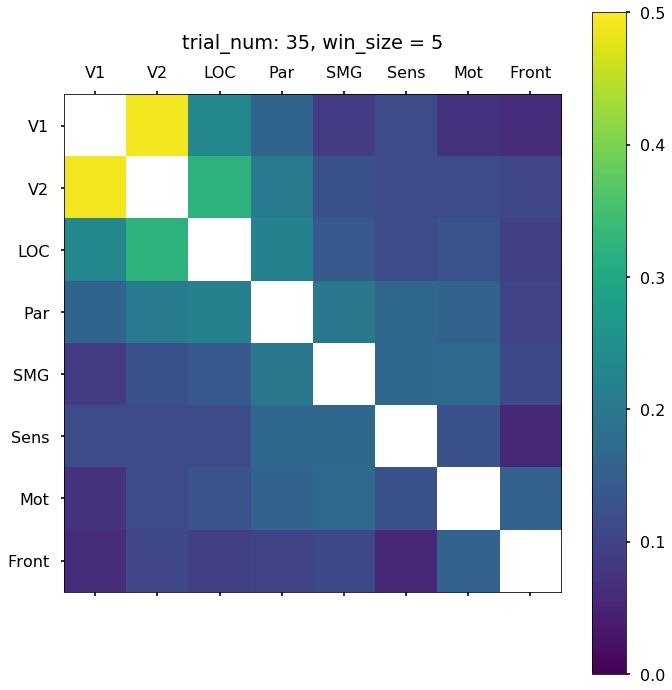

In [50]:
ALLDM = pd.read_csv(str(main_dir)+'csv/logistic_timeseries_drawing_neural_2wayDraw_logged.csv')

# if you decided to use moving window, default step size is 1, unless you want them discrete / binned
# If you decided to use individual time points, then step and windowsize are both 1.
if moving:
    step = 1
    if discrete:
        step = windowsize
else:
    step = 1
    windowsize = 1

# depending on your chosen unit, the parameters for the looping change    
if by == 'trial_num':
    by_out = 'trial'
    low = 0
    high = 40
elif by == 'time_point':
    by_out = 'TR'
    low = 1
    high = 24

_sub_list = np.unique(ALLDM['subj'])
_roi_list = ['V1Draw','V2Draw', 'LOCDraw', 'parietalDraw', 'smgDraw', 
             'sensoryDraw', 'motorDraw', 'frontalDraw']
roi_name = ['V1', 'V2', 'LOC', 'Par', 'SMG', 'Sens', 'Mot', 'Front']
images = []
all_all = []

# Depending on choices made in prior cell, this will step through your chosen time interval
for point in range(low,high-windowsize+1,step):
    bottom = point
    top = point + windowsize
    # reduce to only data in relevant range for this loop
    _ALLDM = ALLDM[ALLDM[by]>=bottom]
    __ALLDM = _ALLDM[_ALLDM[by]<top]
    all_corrs = []
    for sub in _sub_list:
        
        # reduce to only relevant subject
        sub_only = __ALLDM[__ALLDM['subj']==sub]
        drawpreds = []
        for roi in _roi_list:
            # reduce to onyl relevant roi
            roi_only = sub_only[sub_only['roi']==roi]
            t1 = np.array(roi_only['t1_prob'])
            t2 = np.array(roi_only['t2_prob'])
            assert t1.shape == t2.shape
            trained = np.hstack((t1,t2))
            drawpreds.append(trained)
        drawpreds = np.array(drawpreds)
        corrs = np.corrcoef(drawpreds)
        # stack correlations from each subject
        all_corrs = corrs if len(all_corrs) == 0 else np.dstack((all_corrs, corrs))
    all_corrs = np.array(all_corrs)
    # do one sample t test for each
    t, p = stats.ttest_1samp(all_corrs, 0, axis=2)
    clear_output(wait=True)
    all_collapse = np.mean(all_corrs, axis=2)
    np.place(all_collapse, all_collapse>0.9, np.nan)
    # plot the output for each time point
    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.matshow(all_collapse, vmin = 0, vmax = 0.5)
    ax.set_xticklabels(['']+roi_name)
    ax.set_yticklabels(['']+roi_name)
    plt.colorbar(im)
    smoothing = ', win_size = {}'.format(windowsize) if windowsize > 1 else ''
    plt.title(str(by) + ': '+ str(point) + str(smoothing), y=1.08)
    plt.tight_layout()
    if save_fig:
        plt.savefig(str(put_plots)+str(by_out)+'_'+str(point)+'.png')
        currIm = Image.open(str(put_plots)+str(by_out)+'_'+str(point) + '.png')
        images.append(currIm)
    plt.show() if show_fig else plt.close()

# giffify results
if save_fig:
    images = [np.array(image) for image in images]
    imageio.mimsave(str(put_plots)+'all_mats_' + str(by_out) + '.gif', images, duration=0.5)

 ## Fuzzy C Means clustering analysis
 
 https://pythonhosted.org/scikit-fuzzy/api/skfuzzy.html#cmeans

In [52]:
import skfuzzy as fuzz

In [ ]:
end = None
all_mean_clust = all_mean
num = 8

# replace nans with 1 so it will run
all_mean_clust[np.isnan(all_mean_clust)]=1
fpcs = []
which_clusters = []
# explore the number of clusters, likely want to compare 2, 3, and 4. 5 clusters for 8 ROIs is too many
for ncenters in range(2,5):
    # m is a fuzzification constant, high number is more fuzzification
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(all_mean_clust[:,:], 
                                                     ncenters, 
                                                     2, 
                                                     error=0.000000000000001, 
                                                     maxiter=100000000, 
                                                     init=None)
    if ncenters == 2:
        clusts = cntr
    which_cluster = np.argmax(u, axis=0)
    which_clusters = which_cluster if len(which_clusters) == 0 else np.vstack((which_clusters, which_cluster))
    fpcs.append(fpc)  


centers = np.expand_dims(np.arange(2,5),1)
fpcs = np.expand_dims(np.array(fpcs),1)
col_names = np.insert(roi_name[:end],0,'num_clusters')
col_names = np.append(col_names,'fpc')
results_frame = pd.DataFrame(np.hstack((centers,which_clusters, fpcs)), columns= col_names)

print(results_frame)

Typically, two clusters will either come out as more or less the same as four, or much better.
Also, the solution for 2 and 3 clusters is always the same, while the solution for 4, seems to have a few local minima, where the solution varies in whether ANY rois load maximally on a fourth factor

In [58]:
us = []
for i in range((all_corrs.shape[2])):
    all_mean_clust = all_corrs[:end,:end,i]
    u, u0, d, jm, p, fpc = fuzz.cluster.cmeans_predict(all_mean_clust, clusts, 2, error=0.005, maxiter=1000)
    which_cluster = np.argmax(u, axis=0)
    us = np.array(u) if len(us)==0 else np.dstack((us,u))


In [59]:
us_mean = np.mean(us, axis=2)
us_std = np.std(us, axis=2)

In [ ]:
#Plot barplot of cluster membership

plt.clf()
indices = np.arange(0,num)
_colors = ['b']*5
colors = ['y']*3
colors.extend(_colors)
fig, ax = plt.subplots(figsize = (12,7))
series1 = ax.bar(indices, us_mean[0]-0.5, 0.75, color=colors, yerr=us_std[0], zorder=-1, capsize=2.5)
ax.set_title('Cluster 1 Membership')
ax.set_ylabel('Probability of Cluster')
ax.set_xticks(indices)
ax.axhline(lw=0.5, c=(0,0,0,0.6))
ax.set_xticklabels(roi_name)
ax.set_xlabel('ROI')
plt.show()

In [ ]:
# produce bootstrap CIs for later plotting

iters = 3000
boot_means = []
for i in np.arange(iters):
    inds = np.random.RandomState(i).choice(us.shape[2],us.shape[2])
    boot = us[...,inds]
    boot_mean = np.mean(boot[0], axis=1) - 0.5
    boot_means.append(boot_mean)
U = np.mean(boot_means, axis=0)
lb = np.percentile(boot_means, 2.5, axis=0)
ub = np.percentile(boot_means, 97.5, axis=0)

print(np.around(np.vstack((U,lb,ub)),3))


In [62]:
# Create a dataframe with the clustering strength

_all_coefs = []
for subj in range(us.shape[2]):
    subject = _sub_list[subj]
    cluster1 = np.around(np.mean((us[0,:3,subj]-0.5)),4)
    cluster2 = np.around(np.mean((us[0,4:,subj]-0.5)),4)
    clusters = np.around(np.absolute(cluster1) + np.absolute(cluster2) / 2,4)
    parietal = np.around(us[0,3,subj]-0.5,4)
    coefs = np.array((subject,cluster1, parietal, cluster2, clusters))
    _all_coefs = coefs if len(_all_coefs) == 0 else np.vstack((_all_coefs,coefs))
    

In [63]:
all_coefs = pd.DataFrame(_all_coefs, columns = ['subj', 'evc_clust', 'parietal', 'sm_clust', 'all_clust'])
all_coefs.to_csv(str(main_dir)+'csv/drawing_clustering_strength.csv')

In [ ]:
# Creater boxplot for strength of cluster 1, cluster 2, and affiliation of parietal

fig, ax = plt.subplots()
boxer = ax.boxplot([np.array(all_coefs['evc_clust']), 
                    np.array(all_coefs['sm_clust']), 
                    np.array(all_coefs['parietal'])], 
                    positions=[0,1,2],
                    patch_artist=True)
colors = ['y','b','g']

for patch, color in zip(boxer['boxes'], colors):
        patch.set_facecolor(color)
ax.axhline(lw=0.5, color='black')
ax.set_xticklabels(['cluster1', 'cluster2', 'parietal'])
plt.show()

#### Compare first and second half clustering

In [65]:
### TODO: generate these files above
half1 = pd.read_csv(str(main_dir)+'csv/drawing_clustering_strength_half1.csv')
half2 = pd.read_csv(str(main_dir)+'csv/drawing_clustering_strength_half2.csv')
all_coefs = pd.read_csv(str(main_dir)+'csv/drawing_clustering_strength.csv')

IOError: File /home/jefan/neurosketch/csv/drawing_clustering_strength_half1.csv does not exist

In [ ]:
change_with_time = pd.DataFrame(columns = ['subj', 'evc_clust', 'parietal', 'sm_clust', 'all_clust'])

change_with_time['subj'] = half1['subj']
for col in ['evc_clust', 'sm_clust', 'all_clust']:
    change_with_time[col] = np.absolute(half2[col]) - np.absolute(half1[col]) 
change_with_time['parietal'] = half2['parietal'] - half1['parietal']

change_with_time.to_csv(str(main_dir)+'csv/drawing_clustering_strength_change.csv')

#### Does the clustering strength change over time?
#### Does the parietal lobe change 'allegiance' over time?

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(10,4))
boxer = axes[0].boxplot([np.array(change_with_time['evc_clust']), 
                    np.array(change_with_time['sm_clust']), 
                    np.array(change_with_time['all_clust'])], 
                    positions=[0,1,2],
                    patch_artist=True)
boxer2 = axes[1].boxplot(np.array(change_with_time['parietal']),  
                    positions=[0],
                    patch_artist=True)
colors = ['y','b','g']
        

for patch, color in zip(boxer['boxes'], colors):
        patch.set_facecolor(color)
boxer2['boxes'][0].set_color('orange') 
axes[0].axhline(lw=0.5, color='black')
axes[1].axhline(lw=0.5, color='black')
axes[0].set_xticklabels(['cluster1', 'cluster2', 'all_clust'])
axes[1].set_xticklabels(['parietal'])
plt.tight_layout()
plt.show()

#### Compute correlations with clustering strength change and pre/post differentiation

In [ ]:
prepost = pd.read_csv(os.path.join(main_dir,'csv/neural_changes_by_surfroi_and_subject.csv'))
roi_list = ['V1', 'V2', 'LOC', 'IT', 'fusiform', 'parahippo', 'PRC', 'ento','hipp', 'mOFC']
roi_names = ['V1', 'V2', 'LOC', 'IT', 'Fus', 'PHC', 'PRC', 'EC','HC', 'mOFC']

array = change_with_time

corrslist = []
for this_roi in roi_list:
    recog = prepost['UnanchoredTrainedDiff_{}'.format(this_roi)].values-prepost['UnanchoredControlDiff_{}'.format(this_roi)].values
    allstack = np.vstack((recog, array['evc_clust'], array['parietal'], array['sm_clust'], array['all_clust']))
    int_corr = np.corrcoef(allstack)[1:,0]
    corrslist = int_corr if len(corrslist) == 0 else np.vstack((corrslist, int_corr))
fig, ax = plt.subplots(figsize=(8,4))
im = ax.matshow(np.transpose(corrslist))
ax.set_yticks(np.arange(4))
ax.set_yticklabels(['EVC', 'Par', 'Prod', 'All'], fontsize=12)
ax.set_xticks(np.arange(10))
ax.set_xticklabels(roi_names, fontsize=12)
ax.set_xlabel('differentiation', fontsize=16)
ax.set_ylabel('cluster change', fontsize=16)
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
plt.colorbar(im)
    

#### Working cell for agglomerative hierarchical clustering.

In [ ]:
for i in range((all_corrs.shape[2])):
    all_mean_clust = all_corrs[:,:,i]
    all_mean_clust[np.isnan(all_mean_clust)]=1
    clusters = AgglomerativeClustering(n_clusters=3, linkage='average')
    fitted = clusters.fit(all_mean_clust)
    print(fitted.labels_)